# 申请评分卡 Application Scorecard
### 数据来源 Data Source: [Give Me Some Credit (Kaggle Competition)](https://www.kaggle.com/c/GiveMeSomeCredit/data)  
### 内容 Content:
1. 预处理 Preprocessing
2. EDA
3. 模型 (Model)
    + 最优分箱(Optimal binning)，WOE，IV
    + 逻辑回归(Logistic Regression）
    + AUC，KS
4. 评分卡(Scorecard)
    + 计算
    + 稳定性 (Stability)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import random

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

In [2]:
data = pd.read_csv('../scorecard/cs-training.csv').iloc[:,1:]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


# 1. 预处理 Preprocessing

## 1.1 Target

In [3]:
# 使好客户为1，坏客户为0
data['SeriousDlqin2yrs']=1-data['SeriousDlqin2yrs']  

## 1.2 缺失值 Missing Values

### 1.2.1 NumberOfDependents

In [4]:
data['NumberOfDependents'].value_counts()

0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

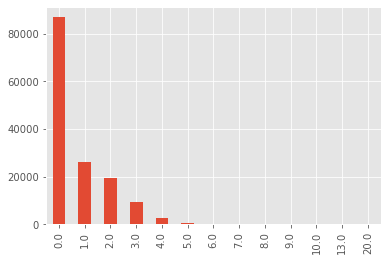

In [5]:
data['NumberOfDependents'].value_counts().plot.bar()

In [6]:
# 从现有数据中进行随机抽样，填充缺失值
Num_Dependents_dropna = data['NumberOfDependents'].dropna().reset_index(drop=True)
fillna_list = random.choices(Num_Dependents_dropna, k = data['NumberOfDependents'].isnull().sum())

In [7]:
i = 0
for row in data.loc[data.NumberOfDependents.isnull(),'NumberOfDependents'].index:
    data.at[row,'NumberOfDependents'] = fillna_list[i]
    i += 1

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      150000 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


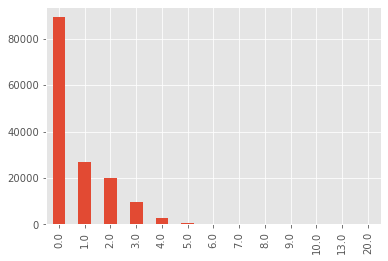

In [9]:
data['NumberOfDependents'].value_counts().plot.bar()

### 1.2.2 MonthlyIncome
使用RandomForest填充缺失值

In [10]:
def fill_MonthlyIncome(df):
    independent_variables = ['RevolvingUtilizationOfUnsecuredLines', 'age','NumberOfTime30-59DaysPastDueNotWorse',
                         'DebtRatio','NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
                         'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']
    dependent_variables = ['MonthlyIncome']

    known_data = df[df.MonthlyIncome.notnull()]
    unknown_data = df[df.MonthlyIncome.isnull()]

    X = known_data[independent_variables]
    y = known_data[dependent_variables]

    rf_model = RandomForestRegressor(n_estimators=200, max_depth=3, n_jobs=-1).fit(X,y)
    pred = rf_model.predict(unknown_data[independent_variables])
    df.loc[df.MonthlyIncome.isnull(),'MonthlyIncome'] = pred
    return df

In [11]:
data = fill_MonthlyIncome(data)

C:\Users\Junbo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


## 1.3 重复项 Duplicates

In [12]:
data.duplicated().sum()

669

In [13]:
data = data.drop_duplicates()
data.shape

(149331, 11)

## 1.4 异常值 Outliers

### 1.4.1 Age

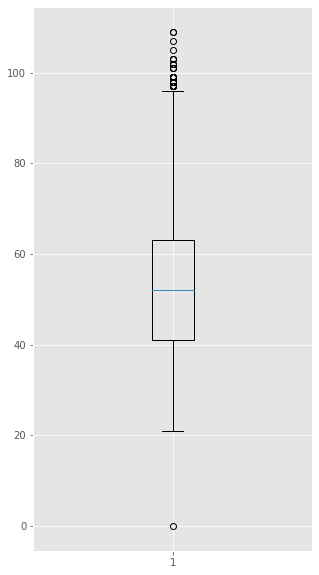

In [14]:
plt.figure(figsize = (5,10))
plt.boxplot(data['age'])
plt.show()

有的年龄超过100岁，需要删除

In [15]:
data = data.loc[(data.age>0)&(data.age<100)]

### 1.4.2 RevolvingUtilizationOfUnsecuredLines & DebtRatio

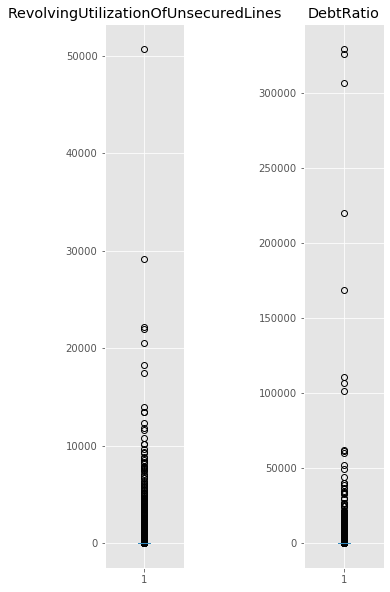

In [16]:
fig,ax = plt.subplots(1,2, figsize = (5,10))
plt.subplots_adjust(wspace=1.5)
ax[0].boxplot(data['RevolvingUtilizationOfUnsecuredLines'])
ax[1].boxplot(data['DebtRatio'])
ax[0].set_title('RevolvingUtilizationOfUnsecuredLines')
ax[1].set_title('DebtRatio')
plt.show()

这两个Feature都是比率，应该在0-1之间

In [17]:
data = data.loc[(data.RevolvingUtilizationOfUnsecuredLines>=0)&(data.RevolvingUtilizationOfUnsecuredLines<=1)]
data = data.loc[(data.DebtRatio>=0)&(data.DebtRatio<=1)]

### 1.4.3 NumberOfTimes: Past Dues

Text(0.5, 1.0, 'NumberOfTimes90DaysLate')

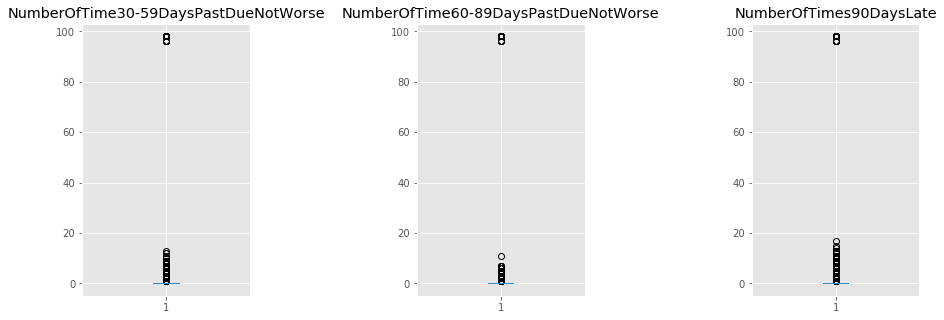

In [18]:
fig,ax = plt.subplots(1,3, figsize=(15,5))
plt.subplots_adjust(wspace=1)
ax[0].boxplot(data['NumberOfTime30-59DaysPastDueNotWorse'])
ax[0].set_title('NumberOfTime30-59DaysPastDueNotWorse')
ax[1].boxplot(data['NumberOfTime60-89DaysPastDueNotWorse'])
ax[1].set_title('NumberOfTime60-89DaysPastDueNotWorse')
ax[2].boxplot(data['NumberOfTimes90DaysLate'])
ax[2].set_title('NumberOfTimes90DaysLate')

每个Feature里面都有2个异常值，需要删除

In [19]:
data = data.loc[(data.NumberOfTimes90DaysLate<=20)&(data['NumberOfTime30-59DaysPastDueNotWorse']<=20)&(data['NumberOfTime60-89DaysPastDueNotWorse']<=20)]

### 1.4.4 MonthlyIncome 

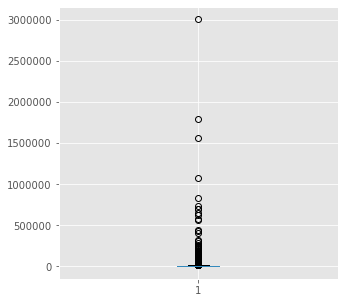

In [20]:
plt.figure(figsize=(5,5))
plt.boxplot(data.MonthlyIncome)
plt.show()

有的月收入超过500000，设定为500000

In [21]:
len(data.loc[data.MonthlyIncome>500000])

12

In [22]:
data.loc[data.MonthlyIncome>500000,'MonthlyIncome'] = 500000

### 1.4.5 NumberOfOpenCreditLinesAndLoans & NumberRealEstateLoansOrLines

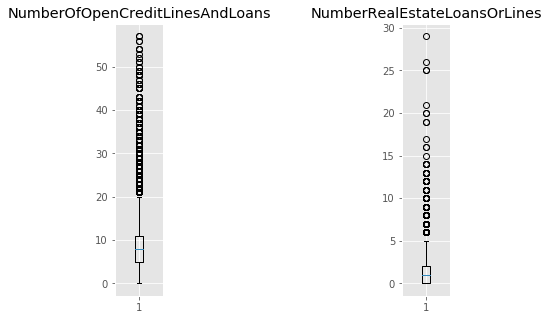

In [23]:
fig,ax = plt.subplots(1,2, figsize = (6,5))
plt.subplots_adjust(wspace=5)
ax[0].boxplot(data['NumberOfOpenCreditLinesAndLoans'])
ax[1].boxplot(data['NumberRealEstateLoansOrLines'])
ax[0].set_title('NumberOfOpenCreditLinesAndLoans')
ax[1].set_title('NumberRealEstateLoansOrLines')
plt.show()

没明显异常值

### 1.4.6 NumberOfDependents

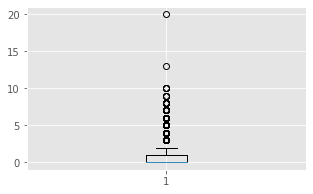

In [24]:
plt.figure(figsize=(5,3))
plt.boxplot(data.NumberOfDependents)
plt.show()

家属人数超过5个的，设定为5个

In [25]:
(data.NumberOfDependents>=5).sum()

848

In [26]:
data.loc[data.NumberOfDependents>=5,'NumberOfDependents'] = 5

# 2. EDA

## 2.1 Tatget

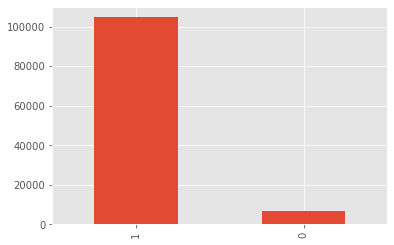

In [27]:
data.SeriousDlqin2yrs.value_counts().plot.bar()

In [28]:
data.SeriousDlqin2yrs.value_counts()/len(data)

1    0.940303
0    0.059697
Name: SeriousDlqin2yrs, dtype: float64

## 2.2 Age

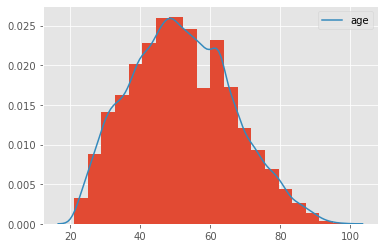

In [29]:
plt.hist(data.age,density=True, bins = 20)
sns.kdeplot(data.age)
plt.show()

## 2.3 Correlation

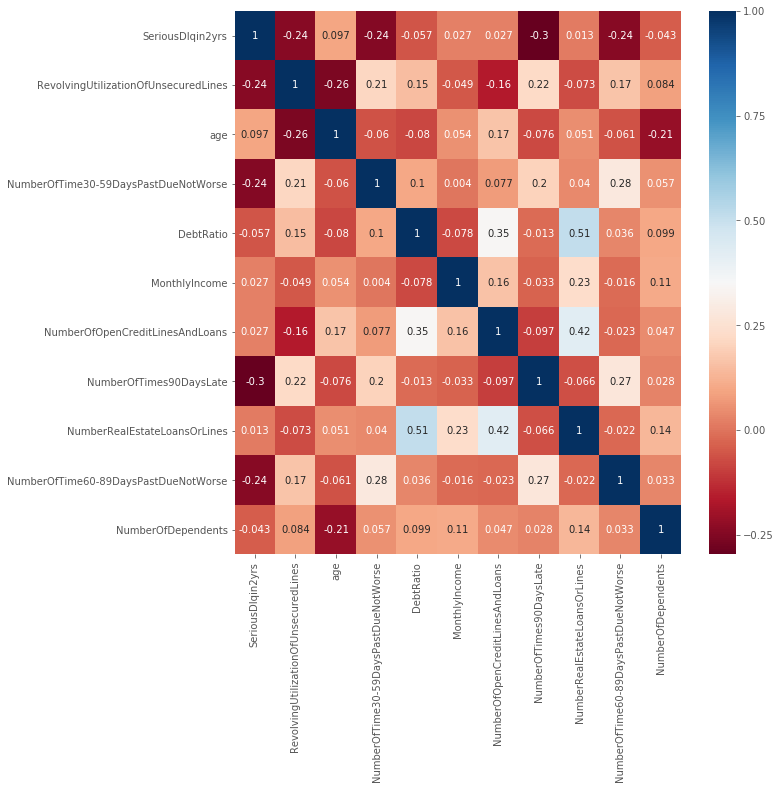

In [30]:
plt.figure(figsize = (10,10))
corr = data.corr()
sns.heatmap(corr, cmap = 'RdBu', annot = True)

# 3. Model

## 3.1 Split Data

In [31]:
from sklearn.model_selection import train_test_split
y = data['SeriousDlqin2yrs']
X = data.drop(columns=['SeriousDlqin2yrs'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)
train = pd.concat([y_train, X_train], axis = 1).reset_index(drop = True)
test = pd.concat([y_test, X_test], axis = 1).reset_index(drop = True)
test.to_csv('../scorecard/origin_test.csv', index = False)

## 3.2 Feature Engineering

### 3.2.1 分箱 Binning
+ 等距分段(Equal length intervals): 分段区间一致,如年龄为十年作为一个分段
+ 等深分段(Equal frequency intervals): 先确定分段数量，然后令每个分段中数据量大致相等
+ 最优分段(Optimal Binning): 根据变量是分布属性，结合改变量对违约状态变量预测能力的变化，将属性接近的数值聚合在一起，形成距离不相等的若干区间，最终得到对违约状态变量预测能力最强的最优分段  

首先选择最优分段，在连续变量分布不满足最优分段要求时，进行等距分段

### Decision Tree based Optimal Binning
这里使用决策树进行最优分箱

In [32]:
def decision_tree_optimal_binning_boundary(X: pd.Series, y: pd.Series, max_leaf_nodes = 6):
    '''
    使用决策树进行最优分箱
    
    输入：X，y, 最多分段数量
    
    输出：分箱边界
    '''
    
    boundary = [float('-inf')]
    
    X = X.values
    y = y.values
    
    clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=max_leaf_nodes, min_samples_leaf=0.05)
    clf.fit(X.reshape(-1,1), y)
    
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right

    boundaries = np.sort(clf.tree_.threshold[children_left != children_right])
    boundary = boundary+ list(boundaries)
    boundary.append(float('inf'))
    
    return boundary

In [33]:
decision_tree_optimal_binning_boundary(X['age'],y)

[-inf, 35.5, 53.5, 56.5, 63.5, 67.5, inf]

### 计算WOE和IV值 WOE & IV for binning features

#### WOE (Weight Of Evidence)：
+ 描述自变量和目标变量之间的预测性关系
+ 计算： ![](https://img-blog.csdnimg.cn/20181206161200197.png)
假设good为好客户（未违约），bad为坏客户（违约）。  
#good(i)表示每组中标签为good的数量，#good(T)为good的总数量；bad相同。

#### IV (Information Value)： 
+ 衡量一个变量的信息量
+ 计算： ![](https://img-blog.csdnimg.cn/20181206161306406.png)
N为分组的组数
+ VI代表一个变量的预测能力

|IV|预测能力|
|-|-|
|< 0.03|无预测能力|
|0.03 - 0.09|弱|
|0.1 - 0.29|中|
|0.3 - 0.49|强|
|> 0.49|极强|

In [34]:
def feature_woe_iv(X: pd.Series, y = pd.Series, binning_function = decision_tree_optimal_binning_boundary,
                   max_leaf_nodes=10, boundary = None):
    '''
    计算WOE和IV值
    
    输入： X, y, 分箱函数（如已经有分箱边界，可忽略），最多分箱数， 分箱边界
    
    输出：
    分箱信息（每组中good数量&百分比、bad数量&百分比、总数、WOE、每组IV）
    分箱IV值
    分箱边界
    '''
    if boundary == None: boundary = binning_function(X,y,max_leaf_nodes)
    if len(boundary) == 2:return None,None,None
    df = pd.concat([X,y], axis = 1)
    df.columns = ['X','y']
    df['bins'] = pd.cut(X, bins = boundary)
    
    grouped = df.groupby('bins')['y']
    result_df = grouped.agg([('good', lambda y:(y==1).sum()),
                            ('bad', lambda y:(y==0).sum()),
                            ('total', 'count')])
    
    result_df['good_pct'] =  result_df['good']/result_df['good'].sum()
    result_df['bad_pct'] = result_df['bad']/result_df['bad'].sum()
    
    result_df['woe'] = np.log(result_df['good_pct']/result_df['bad_pct'])
    result_df['iv'] = (result_df['good_pct']-result_df['bad_pct'])*result_df['woe']
    feature_iv = sum(result_df['iv'])
    
    return result_df, feature_iv, boundary

In [35]:
feature_woe_iv(X['age'],y)

(               good   bad  total  good_pct   bad_pct       woe        iv
 bins                                                                    
 (-inf, 29.5]   5881   663   6544  0.056146  0.099699 -0.574205  0.025009
 (29.5, 35.5]   9091   894   9985  0.086792  0.134436 -0.437578  0.020848
 (35.5, 42.5]  14198  1204  15402  0.135548  0.181053 -0.289460  0.013172
 (42.5, 53.5]  28368  2121  30489  0.270829  0.318947 -0.163538  0.007869
 (53.5, 56.5]   7452   438   7890  0.071144  0.065865  0.077107  0.000407
 (56.5, 60.5]   9313   445   9758  0.088911  0.066917  0.284180  0.006250
 (60.5, 63.5]   7406   305   7711  0.070705  0.045865  0.432822  0.010751
 (63.5, 67.5]   7257   223   7480  0.069283  0.033534  0.725638  0.025941
 (67.5, 74.5]   8263   202   8465  0.078887  0.030376  0.954363  0.046297
 (74.5, inf]    7516   155   7671  0.071755  0.023308  1.124452  0.054476,
 0.21102020649379816,
 [-inf, 29.5, 35.5, 42.5, 53.5, 56.5, 60.5, 63.5, 67.5, 74.5, inf])

In [36]:
# 不能使用最优分箱？

### 选择最优分箱 Choose optimal No. of bins
根据IV值来调整分箱结构并重新计算WOE和IV，直到IV达到最大值，此时的分箱效果最好。

In [37]:
def choose_num_bins(X, y, range_of_num_bins=range(5,21)):
    '''
    选择最优分箱（分箱数量）
    
    策略：最大化IV值
    
    输入： X，y, 分箱数量范围
    
    输出：
    最优分箱数量
    分箱信息（每组中good数量&百分比、bad数量&百分比、总数、WOE、每组IV）
    分箱IV值
    分箱边界
    '''
    iv_list = []
    for num_bins in range_of_num_bins:
        result_df, iv, boundary = feature_woe_iv(X,y,max_leaf_nodes=num_bins)
        iv_list.append(iv)
    iv_list = pd.Series(iv_list,index = range_of_num_bins)
    if sum(iv_list.notnull()) == 0: 
        print('Cannot perform optimal binning. Please manually bin the feature.')
        return None,None,None,None
    opt_num_bins = iv_list.idxmax()
    result_df, iv, boundary = feature_woe_iv(X,y,max_leaf_nodes=opt_num_bins)
    return opt_num_bins, result_df, iv, boundary

In [38]:
choose_num_bins(X['NumberOfTime60-89DaysPastDueNotWorse'],y)

Cannot perform optimal binning. Please manually bin the feature.


(None, None, None, None)

### 合并分箱结果 Binning all features

In [39]:
features = ['RevolvingUtilizationOfUnsecuredLines', 'age','NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
'NumberOfDependents']

In [40]:
binning_result_list = []
failed_features = []
for feature in features:
    _, result_df, iv, boundary= choose_num_bins(data[feature],data['SeriousDlqin2yrs'])
    if iv == None:
        failed_features.append(feature)
        print('Feature Name', feature)
        print('\n')
        continue
    binning_result_list.append((feature,result_df,iv,boundary))

Cannot perform optimal binning. Please manually bin the feature.
Feature Name NumberOfTimes90DaysLate


Cannot perform optimal binning. Please manually bin the feature.
Feature Name NumberOfTime60-89DaysPastDueNotWorse




In [41]:
len(binning_result_list)

8

In [42]:
binning_result_list[0]

('RevolvingUtilizationOfUnsecuredLines',
                     good   bad  total  good_pct   bad_pct       woe        iv
 bins                                                                         
 (-inf, 4.96e-06]    7610   254   7864  0.072653  0.038195  0.642972  0.022155
 (4.96e-06, 0.0109]  8619   112   8731  0.082286  0.016842  1.586314  0.103814
 (0.0109, 0.0262]    8599   134   8733  0.082095  0.020150  1.404649  0.087010
 (0.0262, 0.0415]    6397    82   6479  0.061072  0.012331  1.599953  0.077984
 (0.0415, 0.0595]    5796   104   5900  0.055334  0.015639  1.263620  0.050160
 (0.0595, 0.0972]    8364   185   8549  0.079851  0.027820  1.054424  0.054863
 (0.0972, 0.137]     6178   156   6334  0.058981  0.023459  0.921982  0.032751
 (0.137, 0.216]      8948   294   9242  0.085427  0.044211  0.658694  0.027149
 (0.216, 0.314]      8092   324   8416  0.077254  0.048722  0.460976  0.013153
 (0.314, 0.397]      5349   287   5636  0.051067  0.043158  0.168271  0.001331
 (0.397, 0.

### 手动分箱 Manual feature binning
分箱依据：业务经验

In [43]:
cut_90 = [float('-inf'),0,1,3,5,float('inf')]
cut_60_89 = [float('-inf'),0,1,3,float('inf')]

In [44]:
result_df_90, iv_90, boundary_90 = feature_woe_iv(data['NumberOfTimes90DaysLate'], data['SeriousDlqin2yrs'], boundary=cut_90)
result_df_60, iv_60, boundary_60 = feature_woe_iv(data['NumberOfTime60-89DaysPastDueNotWorse'], data['SeriousDlqin2yrs'], boundary=cut_60_89)

In [45]:
# 合并所有分箱结果
binning_result_list.append(('NumberOfTimes90DaysLate', result_df_90, iv_90, boundary_90))
binning_result_list.append(('NumberOfTime60-89DaysPastDueNotWorse', result_df_60, iv_60, boundary_60))

In [46]:
binning_result_list_order = pd.Series([x[0] for x in binning_result_list])
binning_result_list_order

0    RevolvingUtilizationOfUnsecuredLines
1                                     age
2    NumberOfTime30-59DaysPastDueNotWorse
3                               DebtRatio
4                           MonthlyIncome
5         NumberOfOpenCreditLinesAndLoans
6            NumberRealEstateLoansOrLines
7                      NumberOfDependents
8                 NumberOfTimes90DaysLate
9    NumberOfTime60-89DaysPastDueNotWorse
dtype: object

## 3.3 特征选择 Feature Selection
根据IV值选择特征

|IV|预测能力|
|-|-|
|< 0.03|无预测能力|
|0.03 - 0.09|弱|
|0.1 - 0.29|中|
|0.3 - 0.49|强|
|> 0.49|极强|

删除IV值<0.1的特征

In [47]:
iv_list = [x[2] for x in binning_result_list]
iv_list = pd.Series(iv_list, index = [x for x in features if x not in failed_features]+failed_features)
iv_list

RevolvingUtilizationOfUnsecuredLines    0.931978
age                                     0.211697
NumberOfTime30-59DaysPastDueNotWorse    0.537583
DebtRatio                               0.085336
MonthlyIncome                           0.078866
NumberOfOpenCreditLinesAndLoans         0.084424
NumberRealEstateLoansOrLines            0.039290
NumberOfDependents                      0.032074
NumberOfTimes90DaysLate                 0.769158
NumberOfTime60-89DaysPastDueNotWorse    0.475647
dtype: float64

Text(0, 0.5, 'IV')

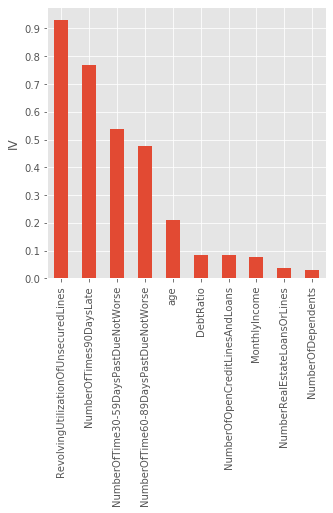

In [48]:
plt.figure(figsize = (5,5))
plt.yticks(np.arange(0,1,0.1))
iv_list.sort_values(ascending=False).plot.bar()
plt.ylabel('IV')

将IV值小于0.1的变量删去  (即`DebtRatio`、`MonthlyIncome`、`NumberOfOpenCreditLinesAndLoans`、`NumberRealEstateLoansOrLines`和`NumberOfDependents`)

## 3.4 WOE转换 WOE Transformation
把特征值转换为WOE


In [49]:
def woe_transformation(df, binning_result_df_list):
    '''
    把特征值转换为WOE
    
    输入： 元素数据， 分箱结果（特征顺序要一一对应）
    
    输出： 转换后的数据
    '''
    df_binned = df[[x[0] for x in binning_result_df_list]]
    for i in range(0,df_binned.shape[1]):
        woe_dict = binning_result_df_list[i][1]['woe'].to_dict() # 设定特征对应的WOE字典
        df_binned.iloc[:,i] = df_binned.iloc[:,i].map(woe_dict)
    
    return df_binned

In [50]:
features_to_keep = iv_list[iv_list > 0.1].index
X_train_woe = woe_transformation(X_train, binning_result_list)[features_to_keep]
X_test_woe = woe_transformation(X_test, binning_result_list)[features_to_keep]

In [51]:
X_train.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
54690,0.008853,48,0,0.050216,4400.0,3,0,0,0,4.0
128280,0.038451,71,0,0.013485,3262.0,5,0,0,0,0.0
27990,0.034552,31,0,0.048670,5300.0,11,0,0,0,0.0
23925,0.372863,42,0,0.301434,23500.0,10,0,3,0,3.0
71213,0.031309,35,0,0.743851,3333.0,14,0,1,0,0.0


## 3.5 逻辑回归 Logistic Regression
**为什么选择logistic？**  
$$p=\frac{1}{1+e^{-\theta^T x}}  \Rightarrow  ln(\frac{p}{1-p})=\theta^T x =  \theta_{0}+\theta_{1}x_{1}+...+\theta_{n}x_{n}$$
方便制作评分卡

In [52]:
import statsmodels.api as sm
X_train_constant = sm.add_constant(X_train_woe)
logistic_model = sm.Logit(y_train,X_train_constant)
model_result = logistic_model.fit()
print(model_result.summary())

Optimization terminated successfully.
         Current function value: 0.176814
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:                89116
Model:                          Logit   Df Residuals:                    89110
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Mar 2020   Pseudo R-squ.:                  0.2146
Time:                        15:27:17   Log-Likelihood:                -15757.
converged:                       True   LL-Null:                       -20061.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    2.7370      0.0

C:\Users\Junbo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


所有特征均显著

In [53]:
coef = model_result.params

## 3.6 评价模型 Model Evaluation
**主要使用AUC和KS**
#### KS
+ KS用于模型风险区分能力进行评估，KS指标衡量的是好坏样本累计分布之间的差值。  
好坏样本累计差异越大，KS指标越大，那么模型的风险区分能力越强。
+ KS的计算步骤如下：
    1. 计算每个评分区间的好坏账户数（计算的是特征的KS的话，是每个特征对应的好坏账户数）。
    2. 计算每个评分区间的累计好账户数占总好账户数比率(good%)和累计坏账户数占总坏账户数比率(bad%)。
    3. 计算每个评分区间累计坏账户占比与累计好账户占比差的绝对值（累计good%-累计bad%），然后对这些绝对值取最大值即得此评分卡的KS值。
+ KS简便计算： $KS = max(TPR-FPR)$
+ KS>0.2代表有较好预测准确性

#### 图像区别：
+ ROC曲线用FPR作为横轴，TPR作为纵轴，采用描点法绘制，图中总共是一条线
+ KS曲线的横轴则是不同的概率判断阈值，图中一共有两条线，分别代表了FPR值和TPR值

In [54]:
X_test_constant = sm.add_constant(X_test_woe)
y_pred = model_result.predict(X_test_constant)

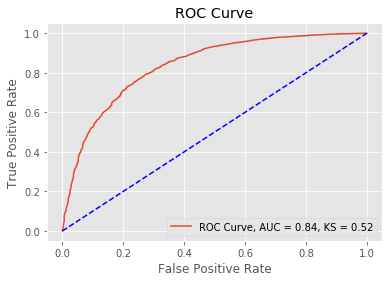

In [55]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fpr,tpr,threshold = roc_curve(y_test,y_pred)
plt.plot(fpr, tpr, label = 'ROC Curve, AUC = {:.2f}, KS = {:.2f}'.format(roc_auc_score(y_test,y_pred), max(tpr-fpr)))
plt.plot((0,1), (0,1), linestyle='dashed', color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

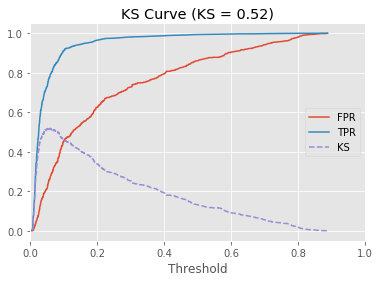

In [56]:
plt.xlim(0,1)
plt.plot(1-threshold, fpr, label = 'FPR')
plt.plot(1-threshold, tpr, label = 'TPR')
plt.plot(1-threshold, tpr-fpr, label = 'KS', linestyle= 'dashed')
plt.legend()
plt.xlabel('Threshold')
plt.title('KS Curve (KS = {:.2f})'.format(max(tpr-fpr)))
plt.show()

模型AUC达到0.84，KS达到0.51， 说明分类效果较好

# 4. 评分卡 Scorecard

**表达式：**评分卡设定的分值刻度可以通过将分值表示为比率对数的现行表达式来定义。公式如下：

$$score_{总}=A+B*ln(odds)=A+B*ln(\theta)$$

$$其中 \theta (odds/好坏比)：\theta=\frac{好客户概率}{坏客户概率}=\frac{p}{1-p}, p是模型预测结果\Rightarrow ln(\theta) = ln(\frac{p}{1-p}) = \theta^T x = \theta_{0}+\theta_{1}x_{1}+...+\theta_{n}x_{n}$$

$$综上\Rightarrow score_{总}=A+B*(\theta^T x)=A+B*( \theta_{0}+\theta_{1}x_{1}+...+\theta_{n}x_{n}) = (A+B*\theta_{0}) + B*\theta_{1}x_{1}+...+B*\theta_{n}x_{n}$$


+ 这里$\theta_{1},\theta_{2},...\theta_{n}$是Logistic Regression中不同变量$x_{1},x_{2},...x_{n}$的系数。$\theta_{0}$是截距。  
+ $(A+B*\theta_{0})$为基础分数，$B*\theta_{1}x_{1}+...+B*\theta_{n}x_{n}$为每个变量对应分配到的分数。  
+ 假设第n个变量被分成k组，$x_{n}$代表该特征值所在组的WOE值, 即$x_{n}=\left\{
\begin{aligned}
WOE_{n,1}\text{,  if in Group 1}\\
WOE_{n,2}\text{,  if in Group 2}\\
...\\
WOE_{n,k}\text{,  if in Group k}\\
\end{aligned}
\right.$

## 4.1 基本分 Baes Score
$A+B*\theta_{0}$  

**假设：**
+ 基础分：600
+ PDO(points to double the odds): 20  
    + odds：$好坏比 \theta=\frac{好客户概率}{坏客户概率}=\frac{p}{1-p}$, 其中p是模型预测结果
    + PDO: 好坏比翻一倍所需要的分数

根据PDO定义，假设比率为$\theta$（也就是odds）的特定点分值为$P_{0}$，比率为$2\theta$的点的分值为$P_{0}+PDO$
则有：
$$ \left\{
\begin{aligned}
P_{0}=A+B*ln(\theta)\\
P_{0}+PDO=A+B*ln(2\theta)\\
\end{aligned}
\right.
\Rightarrow 
\left\{
\begin{aligned}
B=\frac{PDO}{ln(2)}\\
A=P_{0}-Bln(\theta)\\
\end{aligned}
\right.
$$

In [57]:
theta = y_train.value_counts()[1]/y_train.value_counts()[0]
B = 20/np.log(2) # B:刻度
A = 600 - B*np.log(theta) # A:补偿
base_score = round(A+B*coef[0])
base_score

599.0

## 4.2 特征分 Feature Scores
$B*\theta_{1}x_{1}+...+B*\theta_{n}x_{n}$

In [58]:
# 输入变量
binning_result_list_order[binning_result_list_order.apply(lambda x: True if x in features_to_keep else False).values]

0    RevolvingUtilizationOfUnsecuredLines
1                                     age
2    NumberOfTime30-59DaysPastDueNotWorse
8                 NumberOfTimes90DaysLate
9    NumberOfTime60-89DaysPastDueNotWorse
dtype: object

In [59]:
def transform_features_to_woe(input_features: list, binning_result_df_list = binning_result_list):
    feature_index = binning_result_list_order[binning_result_list_order.apply(lambda x: True if x in features_to_keep else False).values].index
    i = 0
    input_features_woe = []
    for idx in feature_index:
        woe_dict = binning_result_df_list[idx][1]['woe'].to_dict()
        input_features_woe.append(pd.Series(input_features[i]).map(woe_dict)[0])
        i += 1
    return input_features_woe

In [60]:
feature_woe = transform_features_to_woe([3,35,2,1,1],binning_result_list)
feature_woe

[-1.3038835159658944,
 -0.43757755335000137,
 -1.2061258645877135,
 -1.9626520373918803,
 -1.792717206346416]

In [61]:
sum(feature_woe*coef[1:])*B

-106.47831373567301

## 4.3 总分 Total Score = Base Score + Feature Scores

In [62]:
def total_score(input_features, base_score = 600, PDO = 20, binning_result_df_list = binning_result_list):
    B = PDO/np.log(2)
    A = base_score - B*np.log(theta)
    base_score = round(A+B*coef[0],0)
    
    feature_woe = transform_features_to_woe(input_features,binning_result_df_list)
    feature_score = sum(feature_woe*coef[1:])*B
    
    total_score = round(base_score+feature_score,0)
    
    return total_score

In [63]:
total_score([3,35,2,1,float(1)],600,20,binning_result_list)

493.0

In [64]:
X_test

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
99851,0.375708,53,0,0.636202,2242.0,7,0,2,0,0.0
19621,0.012795,65,0,0.324656,4801.0,14,0,1,0,0.0
126890,0.060030,58,0,0.325334,8000.0,12,0,2,0,1.0
86368,0.315912,44,0,0.148515,1817.0,5,0,0,0,1.0
145259,0.182295,49,0,0.401769,2600.0,14,0,2,0,1.0
...,...,...,...,...,...,...,...,...,...,...
75410,0.043703,71,0,0.155033,10500.0,12,0,2,0,0.0
83572,0.030538,73,0,0.086456,2694.0,16,0,1,0,0.0
49615,1.000000,46,0,0.523433,4800.0,2,0,1,0,2.0
41880,0.077993,55,0,0.314211,8000.0,6,0,2,0,2.0


In [65]:
#运算需要一点时间
test_score = X_test[features_to_keep].apply(total_score,axis = 1)

In [66]:
test_score_df = pd.concat([y_test,test_score],axis = 1)
test_score_df.columns = ['SeriousDlqin2yrs', 'Score']

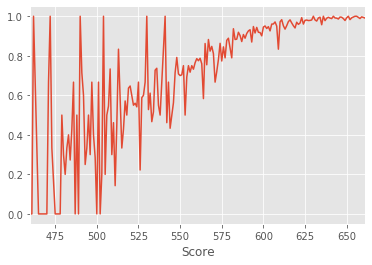

In [67]:
test_score_df.groupby('Score')['SeriousDlqin2yrs'].mean().plot()

分数越高，违约几率越小

In [68]:
# 评分卡
test_score_card = pd.concat([X_test[features_to_keep],test_score_df],axis = 1)
test_score_card.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,SeriousDlqin2yrs,Score
99851,0.375708,53,0,0,0,1,617.0
19621,0.012795,65,0,0,0,1,652.0
126890,0.060030,58,0,0,0,1,639.0
86368,0.315912,44,0,0,0,1,617.0
145259,0.182295,49,0,0,0,1,626.0


## 4.4 评分卡稳定性 Scorecard Stability
#### PSI (Population Stability Index)  
+ PSI 用来衡量分数在开发样本和近期样本上的分布变化，反映了分数分布的稳定性。例如对于信用评分卡，如果模型在近期样本上分数分布偏高或者偏低，都会导致近期样本上的PSI变高。在计算PSI的时候，常常以开发样本上的分数分布作为基准(benchmark)。
+ 公式： ![](https://www.zhihu.com/equation?tex=%5Cbegin%7Baligned%7D+PSI+%3D+%5Csum_%7Bi%3D1%7D%5En%28Actual_i%5C%25+-+Expected_i%5C%25%29%5Cln%28%5Cfrac%7BActual_i%5C%25+%7D%7BExpected_i%5C%25%7D%29+%5Cend%7Baligned%7D)
+ 步骤：
    1. 选定基准样本(Beachmark)作为预期分布(Excepted)，一般以训练样本作为Beachmark。
    2. 对预期分布进行分箱，得到每箱样本占比（该箱样本数/总样本数）。一般按照等频方法（每箱的样本数相等）进行分箱，箱数一般设为10。
    3. 按预期分布分箱阈值对实际分布(Actual)进行分箱，计算每箱样本占比。
    4. 按公式 (实际占比-预期占比)/LN(实际占比/预期占比) 计算每箱的Index。
    5. 累加每箱的Index得到最后的PSI。
+ 评价：

|PSI 值|分布变化情况|措施|
|-|-|-|
|< 0.1|分布变化轻微|无|
|0.1 - 0.25|分布变化较小|监控模型的其他评价指标|
|> 0.25|分布变化较大|进行特征分析，调整模型|

In [69]:
#运算需要大量时间
train_score = X_train[features_to_keep].apply(total_score,axis = 1)
train_score_df = pd.concat([y_train,train_score],axis = 1)
train_score_df.columns = ['SeriousDlqin2yrs', 'Score']

In [70]:
def PSI(train_score_df_bins, test_score_df_bins):
    train_boundary = [float('-inf')] + list(pd.qcut(train_score_df_bins['Score'],q=10,retbins=True)[1][1:-1]) + [float('inf')]
    print('分箱边界：',train_boundary)
    
    train_score_df_bins['bins'] = pd.cut(train_score_df_bins['Score'], bins=train_boundary)
    test_score_df_bins['bins'] = pd.cut(test_score_df_bins['Score'], bins=train_boundary)
    
    expected_pct = train_score_df_bins.groupby('bins')['Score'].count()/len(train_score_df_bins)
    actual_pct = test_score_df_bins.groupby('bins')['Score'].count()/len(test_score_df_bins)
    
    PSI_df = pd.DataFrame({'Expected%':expected_pct,'Actual%':actual_pct})
    PSI_df['Difference'] = PSI_df['Actual%']-PSI_df['Expected%']
    PSI_df['Ln_ratio'] = np.log(PSI_df['Actual%']/PSI_df['Expected%'])
    PSI_df['PSI Contribution'] = PSI_df['Difference']*PSI_df['Ln_ratio']
    
    return PSI_df, PSI_df['PSI Contribution'].sum()

In [71]:
PSI_df, PSI = PSI(train_score_df,test_score_df)
print('PSI = ',PSI)

分箱边界： [-inf, 578.0, 594.0, 604.0, 617.0, 624.0, 631.0, 637.0, 643.0, 650.0, inf]
PSI =  0.00015442225840647236


使用OOT数据，PSI值远小于0.1，说明模型非常稳定